Jocelyn Rupp and Julia Rushton
Lab 7

https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Embedding, Input, GlobalAveragePooling1D, Subtract, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant

AI is labeled 1 and Human is labeled 0

In [79]:
data_path = '../AI_Human.csv'
df = pd.read_csv(data_path)

df.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


In [80]:
# display distribution ratios 
df["generated"].value_counts()

0.0    305797
1.0    181438
Name: generated, dtype: int64

In [81]:
X = df["text"].to_numpy()
y = df["generated"].astype(int).to_numpy()
# _, means dont do anythign to the training data returns
_, X, _, y = train_test_split(X, y, test_size=10000, random_state=42, stratify = y)

In [83]:
# Load Glove (use this same code just change the file name for Concept Net)
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

embeddings = load_embeddings('../glove.6B.300d.txt')
embeddings.shape

(400000, 300)

In [84]:
NUM_TOP_WORDS = None # use entire vocabulary!

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(X)
# save as sequences with integers replacing words
# sequence - all the labels (references to the index in the embedding) for one sentence 
sequences = tokenizer.texts_to_sequences(X)

# what word corresponds to what label
word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

Found 41578 unique tokens. Distilled to 41578 top words.


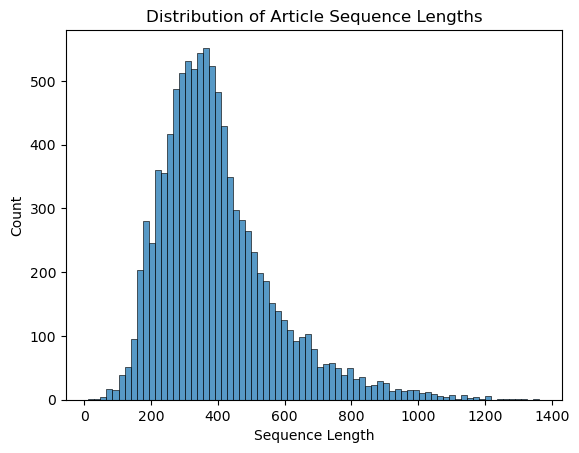

In [85]:
sequence_lengths = list(map(lambda x: len(x), sequences))

sns.histplot(sequence_lengths)

plt.title("Distribution of Article Sequence Lengths")
plt.xlabel("Sequence Length")

plt.show()

In [86]:
MAX_ART_LEN = 1400 # maximum and minimum number of words
X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (10000, 1400)
Shape of label tensor: (10000,)


In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Modeling

In [88]:
# 300 because that is the size of Glove
EMBED_SIZE = 300

def create_embeddings_matrix(embeddings):
    # now fill in the matrix, using the ordering from the
    #  keras word tokenizer from before
    found_words = 0
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
    for word, i in word_index.items():
        try:
            embedding_vector = np.array(embeddings.loc[[word]])
        except:
            continue
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

    print("Embedding Shape:",embedding_matrix.shape, "\n",
        "Total words found:",found_words, "\n",
        "Percentage:",100*found_words/embedding_matrix.shape[0])
    
    return embedding_matrix

embedding_matrix = create_embeddings_matrix(embeddings)

Embedding Shape: (41579, 300) 
 Total words found: 27452 
 Percentage: 66.02371389403305


In [89]:
# first layer of network: find all the embeddings
# save this embedding now
embedding_layer = Embedding(
    len(word_index) + 1,
    EMBED_SIZE,
    embeddings_initializer=Constant(embedding_matrix),# here is the embedding getting saved
    input_length=MAX_ART_LEN,
    trainable=False
)

/Users/Jocelyn/anaconda3/envs/JRenv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# CNN 1:

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 1400)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, 1400, 300) │ 12,473,700 │ input_layer_12[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 1396, 64)  │     96,064 │ embedding_11[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 279, 64)   │          0 │ conv1d_13[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 279, 64)   │          0 │ max_pooling1d_8[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 275, 64)   │     20,544 │ dropout_27[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 55, 64)    │          0 │ conv1d_14[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 55, 64)    │          0 │ max_pooling1d_9[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 51, 64)    │     20,544 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 51, 64)    │          0 │ conv1d_15[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ dropout_29[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_5          │ (None, 51, 64)    │          0 │ dropout_29[0][0], │
│ (Subtract)          │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ power_5 (Power)     │ (None, 51, 64)    │          0 │ subtract_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ power_5[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_1            │ (None, 128)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │      8,256 │ concat_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 64)        │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1)         │         65 │ dropout_30[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,619,173 (48.14 MB)

 Trainable params: 145,473 (568.25 KB)

 Non-trainable params: 12,473,700 (47.58 MB)

None


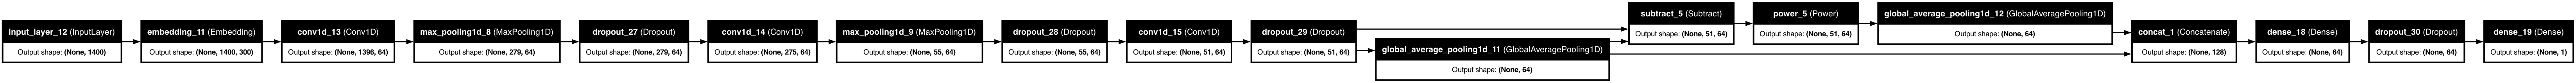

In [90]:
# the input is a list of integers, 500 long
sequence_input = Input(shape=(X_train.shape[1], ))

# this will reduce the input dimension from VOCAB_SIZE to 50 for each word
# the lenght will be the maximum number of words in a document, so 500
embedded_sequences = embedding_layer(sequence_input)

# starting sequence size is 500 (words) by 50 (embedded features)
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, length becomes: 500-4=496 
# so overall size is 496 by 64

# now pool across time
x = MaxPooling1D(5)(x)# after max pool, 496/5 -> 99 by 64
x = Dropout(0.2)(x)

# extract additional features
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 95 after the conovlutions
x = MaxPooling1D(5)(x) # after max pool, size is 95/5 = 19 by 64
x = Dropout(0.2)(x)

# more features through CNN processing!
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)

# after convolution, size becomes 15 elements long
# Take the mean of these elements across features, result is 64 elements
x_mean = GlobalAveragePooling1D()(x) # this is the size to globally flatten 

# Take the variance of these elements across features, result is 64 elements
x_tmp = Subtract()([x,x_mean])
x_std = GlobalAveragePooling1D()(x_tmp**2)

x = Concatenate(name='concat_1')([x_mean,x_std])

x = Dense(64, activation='relu',
          kernel_initializer='he_uniform')(x)

x = Dropout(0.2)(x)

preds = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

model1 = Model(sequence_input, preds)

print(model1.summary())

# you will need to install pydot properly on your machine to get this running
plot_model(
    model1, to_file='model1.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [91]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay


lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.95,
    staircase=True) 
# clipnorm=1.0, 

opt = Adam(epsilon=0.0001, learning_rate=lr_schedule)
model1.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['acc'])

In [92]:
history1 = []
tmp = model1.fit(X_train, y_train, epochs=5, 
                batch_size=64, 
                validation_data=(X_test, y_test))
history1.append( tmp )

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 350ms/step - acc: 0.7510 - loss: 0.4804 - val_acc: 0.9115 - val_loss: 0.3009
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 44s 352ms/step - acc: 0.9340 - loss: 0.1888 - val_acc: 0.9505 - val_loss: 0.1585
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 346ms/step - acc: 0.9545 - loss: 0.1362 - val_acc: 0.9485 - val_loss: 0.1601
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 342ms/step - acc: 0.9695 - loss: 0.0920 - val_acc: 0.9570 - val_loss: 0.1189
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 347ms/step - acc: 0.9735 - loss: 0.0764 - val_acc: 0.9630 - val_loss: 0.0995


In [93]:
tmp = model1.fit(X_train, y_train, epochs=5, 
                batch_size=64, 
                validation_data=(X_test, y_test))
history1.append( tmp )

Epoch 1/5


125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 361ms/step - acc: 0.9860 - loss: 0.0395 - val_acc: 0.9615 - val_loss: 0.1144
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 52s 419ms/step - acc: 0.9905 - loss: 0.0309 - val_acc: 0.9680 - val_loss: 0.0847
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 51s 409ms/step - acc: 0.9882 - loss: 0.0360 - val_acc: 0.9750 - val_loss: 0.0598
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 359ms/step - acc: 0.9921 - loss: 0.0236 - val_acc: 0.9775 - val_loss: 0.0883
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 391ms/step - acc: 0.9923 - loss: 0.0264 - val_acc: 0.9785 - val_loss: 0.0673


In [94]:
df.shape 

(487235, 2)

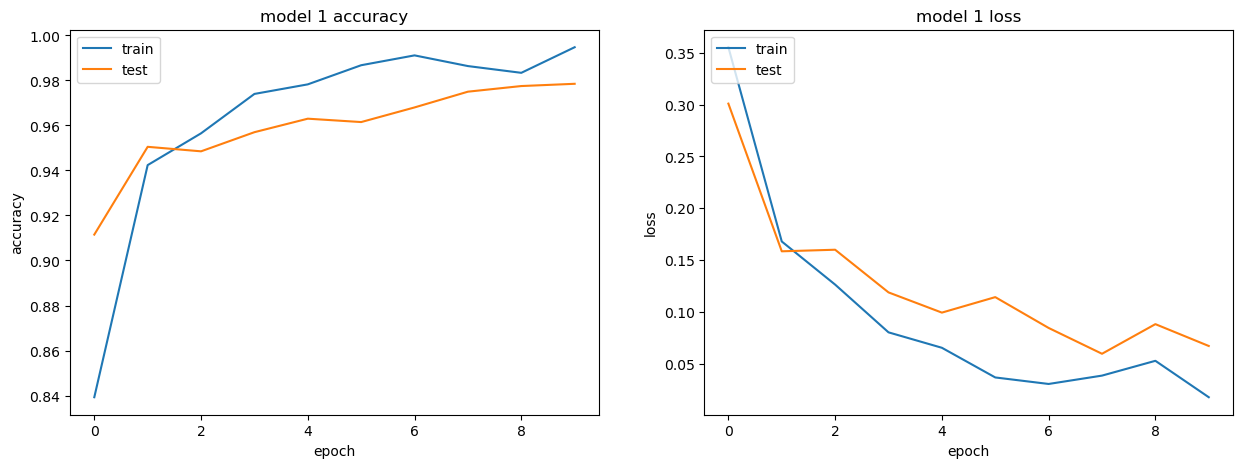

In [95]:
# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history1])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model 1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model 1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [97]:
# Calculate the prediction for model 1
import sklearn.metrics as mt

pred1 = model1.predict(X_test)
yhat1 = np.round(list(map(lambda x: x[0], pred1)))

print(mt.classification_report(y_test, yhat1))
mt.f1_score(y_test, yhat1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1255
           1       0.97      0.97      0.97       745

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



0.9710437710437712

# CNN 2 (with one less layer):

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 1400)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, 1400, 300) │ 12,473,700 │ input_layer_13[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 1396, 64)  │     96,064 │ embedding_11[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 279, 64)   │          0 │ conv1d_16[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 279, 64)   │          0 │ max_pooling1d_10… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 275, 64)   │     20,544 │ dropout_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 275, 64)   │          0 │ conv1d_17[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ dropout_32[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_6          │ (None, 275, 64)   │          0 │ dropout_32[0][0], │
│ (Subtract)          │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ power_6 (Power)     │ (None, 275, 64)   │          0 │ subtract_6[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ power_6[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_1            │ (None, 128)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 64)        │      8,256 │ concat_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 64)        │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 1)         │         65 │ dropout_33[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,598,629 (48.06 MB)

 Trainable params: 124,929 (488.00 KB)

 Non-trainable params: 12,473,700 (47.58 MB)

None


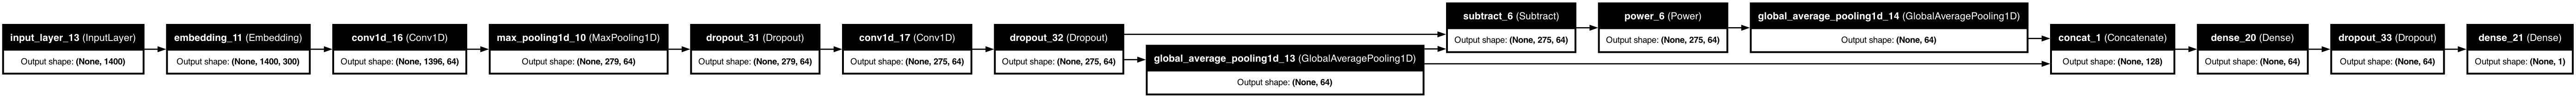

In [98]:
# the input is a list of integers, 500 long
sequence_input = Input(shape=(X_train.shape[1], ))

# this will reduce the input dimension from VOCAB_SIZE to 50 for each word
# the lenght will be the maximum number of words in a document, so 500
embedded_sequences = embedding_layer(sequence_input)

# starting sequence size is 500 (words) by 50 (embedded features)
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, length becomes: 500-4=496 
# so overall size is 496 by 64

# now pool across time
x = MaxPooling1D(5)(x)# after max pool, 496/5 -> 99 by 64
x = Dropout(0.2)(x)

# more features through CNN processing!
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)

# after convolution, size becomes 15 elements long
# Take the mean of these elements across features, result is 64 elements
x_mean = GlobalAveragePooling1D()(x) # this is the size to globally flatten 

# Take the variance of these elements across features, result is 64 elements
x_tmp = Subtract()([x,x_mean])
x_std = GlobalAveragePooling1D()(x_tmp**2)

x = Concatenate(name='concat_1')([x_mean,x_std])

x = Dense(64, activation='relu',
          kernel_initializer='he_uniform')(x)

x = Dropout(0.2)(x)

preds = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

model2 = Model(sequence_input, preds)

print(model2.summary())

# you will need to install pydot properly on your machine to get this running
plot_model(
    model2, to_file='model2.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [99]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.95,
    staircase=True) 
# clipnorm=1.0, 

opt = Adam(epsilon=0.0001, learning_rate=lr_schedule)
model2.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['acc'])

In [100]:
# train model 2
history2 = []
tmp = model2.fit(X_train, y_train, epochs=5, 
                batch_size=64, 
                validation_data=(X_test, y_test))
history2.append( tmp )

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 350ms/step - acc: 0.7227 - loss: 0.5181 - val_acc: 0.9200 - val_loss: 0.2470
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 345ms/step - acc: 0.9207 - loss: 0.2081 - val_acc: 0.9285 - val_loss: 0.1753
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 344ms/step - acc: 0.9521 - loss: 0.1328 - val_acc: 0.9545 - val_loss: 0.1529
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 345ms/step - acc: 0.9644 - loss: 0.0958 - val_acc: 0.9670 - val_loss: 0.1054
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 336ms/step - acc: 0.9746 - loss: 0.0673 - val_acc: 0.9650 - val_loss: 0.1112


In [101]:
tmp = model2.fit(X_train, y_train, epochs=5, 
                batch_size=64, 
                validation_data=(X_test, y_test))
history2.append( tmp )

Epoch 1/5


125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 340ms/step - acc: 0.9800 - loss: 0.0619 - val_acc: 0.9695 - val_loss: 0.0874
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 342ms/step - acc: 0.9865 - loss: 0.0425 - val_acc: 0.9665 - val_loss: 0.1059
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 347ms/step - acc: 0.9873 - loss: 0.0358 - val_acc: 0.9730 - val_loss: 0.0791
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 340ms/step - acc: 0.9915 - loss: 0.0254 - val_acc: 0.9700 - val_loss: 0.0896
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 343ms/step - acc: 0.9903 - loss: 0.0316 - val_acc: 0.9740 - val_loss: 0.0864


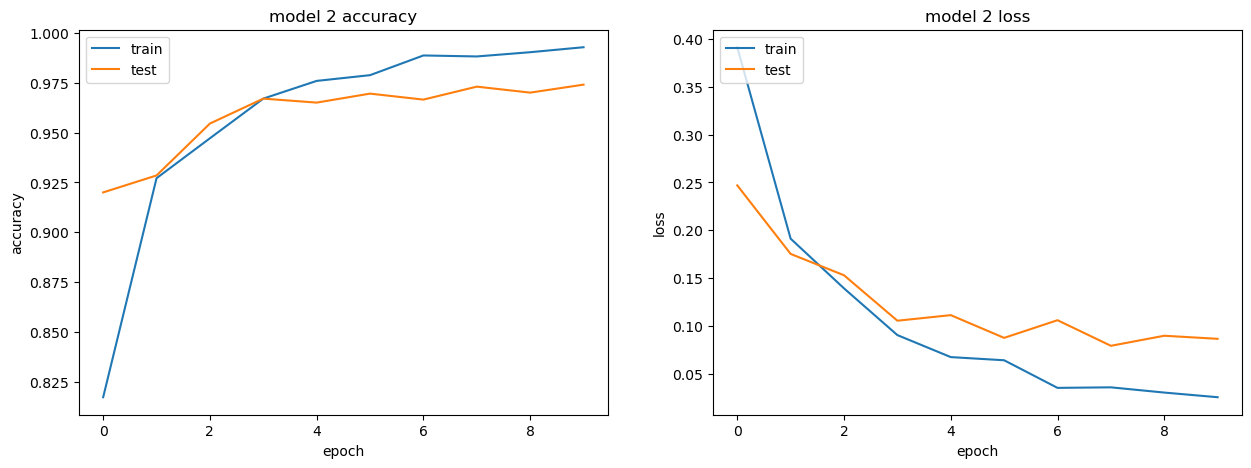

In [102]:
# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history2])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model 2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model 2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [103]:
# calculate predictions for model 2
pred2 = model2.predict(X_test)
yhat2 = np.round(list(map(lambda x: x[0], pred2)))

print(mt.classification_report(y_test, yhat2))
mt.f1_score(y_test, yhat2)

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1255
           1       0.95      0.98      0.97       745

    accuracy                           0.97      2000
   macro avg       0.97      0.98      0.97      2000
weighted avg       0.97      0.97      0.97      2000



0.9656992084432717

Use F1 ad the threshold/confidence level becasue we dont want to prioritize one or the other with falsely assuming a kid using AI to complete their homework or not catching a student that has used AI to complete their homework. False positives for both sides are equally important so the F1 score is perfect for this. 

# Transformer 1 (Model 3)

In [105]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer

# The transformer architecture 
class TransformerBlock(Layer): # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # setup the model heads and feedforward network
        self.att = MultiHeadAttention(num_heads=num_heads, 
                                      key_dim=embed_dim)
        
        # make a two layer network that processes the attention
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation='relu') )
        self.ffn.add( Dense(embed_dim) )
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training = False):
        # apply the layers as needed (similar to PyTorch)
        
        # get the attention output from multi heads
        # Using same inpout here is self-attention
        # call inputs are (query, value, key) 
        # if only two inputs given, value and key are assumed the same
        attn_output = self.att(inputs, inputs)
        
        # create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output)
        
        # apply dropout if training
        out1 = self.dropout1(out1, training=training)
        
        # place through feed forward after layer norm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        
        # apply dropout if training
        out2 = self.dropout2(out2, training=training)
        #return the residual from Dense layer
        return out2
    
class GloveTokenAndPositionEmbedding(Layer):
    def __init__(self):
        super().__init__()
        # create two embeddings 
        # one for processing the tokens, pretrained (words)
        self.token_emb = Embedding(
            len(word_index) + 1,
            EMBED_SIZE,
            embeddings_initializer=Constant(embedding_matrix),# here is the embedding getting saved
            input_length=MAX_ART_LEN,
            trainable=False
        )
        
        # another embedding for processing the position
        self.pos_emb = Embedding(MAX_ART_LEN, 
                                 EMBED_SIZE, 
                                 input_length=MAX_ART_LEN,
                                 trainable=True
                                )

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [107]:
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(20, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

model_xformer3 = Model(inputs=inputs, outputs=outputs)
print(model_xformer3.summary())

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 1400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ glove_token_and_position_embed… │ (None, 1400, 300)      │    12,893,700 │
│ (GloveTokenAndPositionEmbeddin… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_4             │ (None, 1400, 300)      │       742,832 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_16     │ (None, 300)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 20)             │         6,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,642,573 (52.04 MB)

 Trainable params: 1,168,873 (4.46 MB)

 Non-trainable params: 12,473,700 (47.58 MB)

None


In [108]:
model_xformer3.compile(optimizer='adam', 
                      loss='binary_crossentropy', 
                      metrics=['accuracy'])

In [110]:
# train trensformer (Model 3)
history3 = []
tmp = model_xformer3.fit(X_train, y_train, epochs=5, 
                batch_size=64, 
                validation_data=(X_test, y_test))
history3.append( tmp )

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1069s 9s/step - accuracy: 0.9516 - loss: 0.1270 - val_accuracy: 0.9535 - val_loss: 0.1337
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1064s 9s/step - accuracy: 0.9656 - loss: 0.0978 - val_accuracy: 0.9580 - val_loss: 0.1209
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1127s 9s/step - accuracy: 0.9771 - loss: 0.0666 - val_accuracy: 0.9655 - val_loss: 0.1038
Epoch 4/5
 96/125 ━━━━━━━━━━━━━━━━━━━━ 4:00 8s/step - accuracy: 0.9798 - loss: 0.0511

In [ ]:
pred3 = model2.predict(X_test)
yhat3 = np.argmax(pred3, axis = 1)

print(mt.classification_report(y_test, yhat3))
mt.f1_score(y_test, yhat3)

In [ ]:
# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history3])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model 3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model 3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
num_heads = 3  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(20, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

model_xformer3 = Model(inputs=inputs, outputs=outputs)
print(model_xformer3.summary())

In [ ]:
history4 = []
tmp = model_xformer4.fit(X_train, y_train, epochs=5, 
                batch_size=64, 
                validation_data=(X_test, y_test))
history4.append( tmp )

In [ ]:
# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history4])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model 4 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model 4 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
pred4 = model2.predict(X_test)
yhat4 = np.argmax(pred4, axis = 1)

print(mt.classification_report(y_test, yhat4))
mt.f1_score(y_test, yhat4)

In [ ]:
def mcnemar(y, yhat1, yhat2):
    b = 0
    c = 0
    
    for i in range(len(y)):
        if yhat1[i] == yhat2[i]:
            continue
        if yhat1[i] == y[i]:
            b +=1
        else:
            c +=1
            
    m = ((np.abs(b-c) -1) ** 2)/(b+c) 
    print(m)
    # critical value for 95% confidence
    return m > 3.841

In [ ]:
# model 1 vs model 2
mcnemar(y_test, yhat1, yhat2)

In [ ]:
# model 1 vs model 3
mcnemar(y_test, yhat1, yhat3)

In [ ]:
# model 1 vs model 4
mcnemar(y_test, yhat1, yhat4)

In [ ]:
# model 2 vs model 3
mcnemar(y_test, yhat2, yhat3)

In [ ]:
# model 2 vs model 4
mcnemar(y_test, yhat2, yhat4)

In [ ]:
# model 3 vs model 4
mcnemar(y_test, yhat3, yhat4)